# Wrangle data

Let's import all required libraries.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from timeit import default_timer as timer
import json
import pandas as pd
import numpy as np
import requests
import tweepy
import re

import matplotlib.pyplot as plt
import seaborn as sns

## Gathering data

### The WeRateDogs Twitter archive

Load a CSV file with data that I downloaded manually from the Udacity website.

In [2]:
tw_arch = pd.read_csv('data/twitter-archive-enhanced.csv')

### The tweet image predictions

Download a TSV file from Udacity using requests library.

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
resp = requests.get(url)
with open('data/' + url.split('/')[-1], mode='wb') as file:
    file.write(resp.content)

Load the TSV file with pandas.

In [4]:
tw_pred = pd.read_csv('data/image-predictions.tsv', sep='\t')

### Twitter API

Using the tweet IDs in the WeRateDogs Twitter archive, let's query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file.

In [5]:
def download_twitter_data():
    # Query Twitter API for each tweet in the Twitter archive 
    # and save JSON in a text file
    # These are hidden to comply with Twitter's API terms and conditions
    consumer_key = 'HIDDEN'
    consumer_secret = 'HIDDEN'
    access_token = 'HIDDEN'
    access_secret = 'HIDDEN'

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    # Query Twitter's API for JSON data for each tweet ID 
    # in the Twitter archive
    fails_dict = {}
    start = timer()
    # Save each tweet's returned JSON as a new line in a .txt file
    with open('data/tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of 
        # Twitter's rate limit
        for tweet_id in tw_arch.tweet_id.values:
            try:
                tweet = api.get_status(tweet_id)
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail", tweet_id)
                fails_dict[tweet_id] = e
                pass

    end = timer()
    print(end - start)
    print(fails_dict)

In [6]:
# Uncomment this to update 'tweet_json.txt'
download_twitter_data()

Fail 888202515573088257
Fail 873697596434513921
Fail 872668790621863937
Fail 872261713294495745
Fail 869988702071779329
Fail 866816280283807744
Fail 861769973181624320
Fail 856602993587888130
Fail 851953902622658560
Fail 845459076796616705
Fail 844704788403113984
Fail 842892208864923648
Fail 837366284874571778
Fail 837012587749474308
Fail 829374341691346946
Fail 827228250799742977
Fail 812747805718642688
Fail 802247111496568832
Fail 779123168116150273
Fail 775096608509886464
Fail 771004394259247104
Fail 770743923962707968
Fail 759566828574212096


Rate limit reached. Sleeping for: 434


Fail 754011816964026368
Fail 680055455951884288


Rate limit reached. Sleeping for: 426


2104.480035308001
{888202515573088257: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 873697596434513921: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 872668790621863937: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 872261713294495745: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 869988702071779329: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 866816280283807744: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 861769973181624320: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 856602993587888130: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 851953902622658560: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 845459076796616705: TweepError([{'code': 144, 'message': 'No status found with that ID.'}]), 844704788403113984: TweepError([{'code': 144, 'mess

In [7]:
# Read json file line by line into a pandas DataFrame
df_tw = pd.read_json('data/tweet_json.txt', lines=True)

In [8]:
# Select only required columns
df_tw = df_tw[['id', 'favorite_count', 'retweet_count']]

## Assessing the data

In [9]:
# View info of the Twitter archive
tw_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
# View first 5 rows of the archieve
tw_arch.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
# View last 5 rows of the archieve
tw_arch.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [12]:
# Get sample from the archieve
tw_arch.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2088,670792680469889025,NaN,NaN,2015-11-29 02:33:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Antony. He's a Sheraton Tetrahedron. S...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670792680...,7,10,Antony,None,None,None,None
1657,683142553609318400,NaN,NaN,2016-01-02 04:27:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Brandy. She's a member of the Bloods. Men...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683142553...,9,10,Brandy,None,None,pupper,None
750,779123168116150273,NaN,NaN,2016-09-23 01:00:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Reggie. He hugs everyone he meets. 12/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/779123168...,12,10,Reggie,None,None,None,None
1357,703407252292673536,NaN,NaN,2016-02-27 02:32:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper doesn't understand gates. 10/10 so...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703407252...,10,10,None,None,None,pupper,None
1008,747594051852075008,NaN,NaN,2016-06-28 00:54:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Again w the sharks guys. This week is about do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747594051...,11,10,None,None,None,None,None


In [13]:
# View descriptive statistics of the archive
tw_arch.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
# Check for duplicates
tw_arch.tweet_id.duplicated().sum()

0

In [15]:
# Find lowercase names and check them 
tw_arch[tw_arch.name.str.islower()].name.value_counts()

a               55
the              8
an               7
very             5
one              4
just             4
quite            4
getting          2
actually         2
not              2
mad              2
my               1
unacceptable     1
all              1
incredibly       1
officially       1
such             1
light            1
life             1
old              1
by               1
his              1
space            1
infuriating      1
this             1
Name: name, dtype: int64

In [16]:
# Set wider column width to see more information
pd.set_option('max_colwidth', 150)
# Try to find word name in rows where name is lowercase or None
tw_arch[((tw_arch.name == 'None') | tw_arch.name.str.islower())
        & tw_arch.text.str.contains('name')][['text', 'name']]

,text,name
35,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,None
149,"Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https:...",None
168,Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t...,None
603,RT @dog_rates: This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,None
843,His name is Charley and he already has a new set of wheels thanks to donations. I heard his top speed was also increased. 13/10 for Charley,None
852,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,my
1596,When bae calls your name from across the room. 12/10 (vid by @christinemcc98) https://t.co/xolcXA6gxe,None
1678,We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT,None
1734,This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP,None
1853,This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI,a


In [17]:
# Show wrong ratings rows
tw_arch[tw_arch.rating_denominator != 10][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t ...,24,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [18]:
# Show all source options
tw_arch.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [19]:
# View info of the tweet image predictions dataframe
tw_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
# Check for jpg_url duplicates
tw_pred.jpg_url.duplicated().sum()

66

In [21]:
# View first 5 rows of the predictions
tw_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [22]:
# View last 5 rows of the predictions
tw_pred.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [23]:
# Get sample from the predictions
tw_pred.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1380,765222098633691136,https://pbs.twimg.com/media/Cp6db4-XYAAMmqL.jpg,1,dalmatian,0.556595,True,whippet,0.151047,True,American_Staffordshire_terrier,0.096435,True
1166,735635087207878657,https://pbs.twimg.com/media/CjWANBlVAAAaN-a.jpg,1,pug,0.891871,True,goose,0.014377,False,fur_coat,0.008451,False
1801,831939777352105988,https://pbs.twimg.com/media/C4uk0EWWQAAaZm1.jpg,1,Pomeranian,0.153862,True,marmot,0.091234,False,grey_fox,0.090644,False
370,672975131468300288,https://pbs.twimg.com/media/CVbjRSIWsAElw2s.jpg,1,pug,0.836421,True,Brabancon_griffon,0.044668,True,French_bulldog,0.036570,True
1180,738166403467907072,https://pbs.twimg.com/media/Cj5-aUQUgAAb43p.jpg,2,keeshond,0.878886,True,Norwegian_elkhound,0.086659,True,malamute,0.021280,True


In [24]:
# View descriptive statistics of the predictions
tw_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [25]:
# View info of the downloaded tweet data dataframe
df_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2331 non-null   int64
 1   favorite_count  2331 non-null   int64
 2   retweet_count   2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [26]:
# View first 5 rows of the downloaded data
df_tw.head()

,id,favorite_count,retweet_count
0,892420643555336193,36113,7690
1,892177421306343426,31149,5689
2,891815181378084864,23458,3772
3,891689557279858688,39398,7856
4,891327558926688256,37621,8462


In [27]:
# View last 5 rows of the downloaded data
df_tw.tail()

,id,favorite_count,retweet_count
2326,666049248165822465,96,40
2327,666044226329800704,272,131
2328,666033412701032449,112,41
2329,666029285002620928,121,42
2330,666020888022790149,2408,460


In [28]:
# Get sample from the downloaded data
df_tw.sample(5)

,id,favorite_count,retweet_count
1361,700747788515020802,22674,9248
719,780858289093574656,7280,2043
748,777641927919427584,0,4290
512,808344865868283904,43276,21300
981,747651430853525504,1380,155


In [29]:
# View descriptive statistics of the downloaded data
df_tw.describe()

,id,favorite_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7540.806521,2698.289146
std,6.823170e+16,11705.340727,4561.608355
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1317.000000,546.000000
50%,7.182469e+17,3277.000000,1266.000000
75%,7.986692e+17,9234.000000,3137.000000
max,8.924206e+17,155731.000000,77603.000000


### Quality issues
We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.

#### Retweets
We can determine if the row is a retweet when the "retweeted_status_id" column contains a value. Filter out retweet rows and drop unneeded columns.

#### Replies
We can determine if the row is a reply when the "in_reply_to_status_id" column contains a value. Filter out all reply rows and drop unneeded columns.

#### Datatypes
Fix datatypes of "timestamp", "rating_numerator", "rating_denomerator".

#### Source
Remove HTML tags from source and make it more readable.

#### Names
We can notice that all lowercase names are wrong. Also, there are dogs with 'None' names. For several of these rows we can find a name in a text column. Get names from text where possible and filter out others.

#### Ratings
There are rows where text contains several ratings and they were extracted wrongly. Extract right rating where it is possible.

#### Image URL duplicates
There are duplicated img urls. Drop duplicates.

#### Format p1, p2, p3 values
We can notice that some of the values are lowercase and some of them uppercase. Names also have '_' separator. Capitalise all the breeds and replace '_' character with space.

### Tidyness Issues

#### Stage
There are separate columns for every stage. Combine them into a single one.

#### Neural network predictions

There are 3 separate predictions with 3 columns in each. Combine them into 2 columns: breed and conf.

#### Join to a single Master DataFrame
This will allow to get rid of rows without images also.

## Cleaning data

Create copies for every DataFrame.

In [30]:
tw_arch_clean = tw_arch.copy()
tw_pred_clean = tw_pred.copy()
df_tw_clean = df_tw.copy()

### Retweets

#### Code

In [31]:
# Filter out all retweets
tw_arch_clean = tw_arch_clean[tw_arch_clean.retweeted_status_id.isnull()]

#### Test

In [32]:
# Check before drop
tw_arch_clean[[
    'retweeted_status_id', 'retweeted_status_user_id',
    'retweeted_status_timestamp'
]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   retweeted_status_id         0 non-null      float64
 1   retweeted_status_user_id    0 non-null      float64
 2   retweeted_status_timestamp  0 non-null      object 
dtypes: float64(2), object(1)
memory usage: 68.0+ KB


#### Code

In [33]:
# Drop unneeded columns
tw_arch_clean.drop([
    'retweeted_status_id', 'retweeted_status_user_id',
    'retweeted_status_timestamp'
],
                   axis=1,
                   inplace=True)

#### Test

In [34]:
tw_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ 

### Replies

#### Code

In [35]:
# Filter out all replies
tw_arch_clean = tw_arch_clean[tw_arch_clean.in_reply_to_status_id.isnull()]

#### Test

In [36]:
# Check before drop
tw_arch_clean[['in_reply_to_status_id', 'in_reply_to_user_id']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   in_reply_to_status_id  0 non-null      float64
 1   in_reply_to_user_id    0 non-null      float64
dtypes: float64(2)
memory usage: 49.1 KB


#### Code

In [37]:
# Drop unneeded columns
tw_arch_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'],
                   axis=1,
                   inplace=True)

#### Test

In [38]:
tw_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


### Datatypes

#### Code

In [39]:
# Change datatype to datetime
tw_arch_clean['timestamp'] = pd.to_datetime(tw_arch_clean['timestamp'])
# Change datatype to float
tw_arch_clean['rating_numerator'] = tw_arch_clean['rating_numerator'].astype('float')
tw_arch_clean['rating_denominator'] = tw_arch_clean['rating_denominator'].astype('float')

#### Test

In [40]:
tw_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   float64            
 6   rating_denominator  2097 non-null   float64            
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), float64

### Source

#### Code

In [41]:
tw_arch_clean.loc[tw_arch_clean['source'].str.contains('iPhone'), 'source'] = 'iPhone'
tw_arch_clean.loc[tw_arch_clean['source'].str.contains('Vine'), 'source'] = 'Vine'
tw_arch_clean.loc[tw_arch_clean['source'].str.contains('Web'), 'source'] = 'Web'
tw_arch_clean.loc[tw_arch_clean['source'].str.contains('TweetDeck'), 'source'] = 'TweetDeck'

#### Test

In [42]:
tw_arch_clean.source.value_counts()

iPhone       1964
Vine           91
Web            31
TweetDeck      11
Name: source, dtype: int64

### Names

#### Code

In [43]:
# Get rows with word 'name' in text where name is lowercase or None
wrdf = tw_arch_clean[(
    (tw_arch_clean.name == 'None') | tw_arch_clean.name.str.islower())
                    & tw_arch_clean.text.str.contains('name')][['text', 'name']]
wrdf[['text']]

,text
35,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk
168,Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t...
852,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB
1596,When bae calls your name from across the room. 12/10 (vid by @christinemcc98) https://t.co/xolcXA6gxe
1678,We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT
1734,This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP
1853,This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI
1955,This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3
2034,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7
2066,This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr


We can notice that names of a dogs go after 'name is' and 'named'. Also there is a special case 'Big Jumpy Rat' - process it manually.

In [44]:
# Get text column index
text_idx = wrdf.columns.get_loc("text")

# Iterate every row
for index, row in wrdf.iterrows():
    t = row[text_idx]
    
    # Check for name is
    _, _, after = t.partition('name is')
    if after:
        name = after.split()[0].strip(' ,.')
        tw_arch_clean.loc[index, 'name'] = name
        continue

    # Check for named
    _, _, after = t.partition('named')
    if after:
        name = after.split()[0].strip(' ,.')
        tw_arch_clean.loc[index, 'name'] = name
        continue

    # Special case
    if 'Big Jumpy Rat' in t:
        tw_arch_clean.loc[index, 'name'] = 'Big Jumpy Rat'

Now we can filter out the rest cases with wrong names.

In [45]:
tw_arch_clean = tw_arch_clean[(tw_arch_clean.name != 'None')
                              & (tw_arch_clean.name.str.islower() == False)]

Let's look at short names.

In [46]:
tw_arch_clean[tw_arch_clean.name.str.len() < 3][['text', 'name']]

,text,name
393,This is Mo. No one will push him around in the grocery cart. He's quite pupset about it. 11/10 I volunteer https://t.co/feNwTq12S5,Mo
449,This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,Bo
553,This is Bo. He's going to make me cry. 13/10 please get off the bus for him Carly https://t.co/U7FvBZo6Bq,Bo
679,This is Bo. He's a West Congolese Bugaboop Snuggle. Rather exotic. Master of the head tilt. 12/10 would pay to pet https://t.co/2jwxxtNzoN,Bo
775,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,O
820,Meet Al Cabone. He's a gangsta puppa. Rather h*ckin ruthless. Shows no mercy sometimes. 11/10 pet w extreme caution https://t.co/OUwWbEKOUV,Al
876,This is Bo and Ty. Bo eats paper and Ty felt left out. 11/10 for both https://t.co/1acHQS8rvK,Bo
978,This is Bo. He emanates happiness. 12/10 I could cut the freedom with a knife https://t.co/c7LNFt39eR,Bo
1683,This is Bo. He's a Benedoop Cumbersnatch. Seems frustrated with own feet. Portable as hell. 11/10 very solid pupper https://t.co/TONMhRoQh7,Bo
1988,"This is Ed. He's not mad, just disappointed. 10/10 https://t.co/BIljU0zhLN",Ed


We can notice 2 wrong records here. Fix them manually.

In [47]:
tw_arch_clean.loc[775, 'name'] = "O'Malley"
tw_arch_clean.loc[820, 'name'] = "Al Cabone"

#### Test

In [48]:
tw_arch_clean[(tw_arch_clean.name == 'None')
              | tw_arch_clean.name.str.islower()].shape[0]

0

In [49]:
tw_arch_clean[tw_arch_clean.name.str.len() < 3][['text', 'name']]

,text,name
393,This is Mo. No one will push him around in the grocery cart. He's quite pupset about it. 11/10 I volunteer https://t.co/feNwTq12S5,Mo
449,This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,Bo
553,This is Bo. He's going to make me cry. 13/10 please get off the bus for him Carly https://t.co/U7FvBZo6Bq,Bo
679,This is Bo. He's a West Congolese Bugaboop Snuggle. Rather exotic. Master of the head tilt. 12/10 would pay to pet https://t.co/2jwxxtNzoN,Bo
876,This is Bo and Ty. Bo eats paper and Ty felt left out. 11/10 for both https://t.co/1acHQS8rvK,Bo
978,This is Bo. He emanates happiness. 12/10 I could cut the freedom with a knife https://t.co/c7LNFt39eR,Bo
1683,This is Bo. He's a Benedoop Cumbersnatch. Seems frustrated with own feet. Portable as hell. 11/10 very solid pupper https://t.co/TONMhRoQh7,Bo
1988,"This is Ed. He's not mad, just disappointed. 10/10 https://t.co/BIljU0zhLN",Ed
2041,"This is JD (stands for ""just dog""). He's like Airbud but with trading card games instead of sports. 10/10 much skill https://t.co/zzueJV9jCF",JD
2219,This is Jo. Jo is a Swedish Queso. Tongue bigger than face. Tiny lil legs. Still no seatbelt. Simply careless. 8/10 https://t.co/Edy7B5vOp2,Jo


### Ratings

#### Code

In [50]:
# Get column indexes
text_idx = tw_arch_clean.columns.get_loc("text")
numerator_idx = tw_arch_clean.columns.get_loc("rating_numerator")
denominator_idx = tw_arch_clean.columns.get_loc("rating_denominator")
name_idx = tw_arch_clean.columns.get_loc("name")

drop_rows = []
fixed_rows = 0

# Iterate every row
for index, row in tw_arch_clean.iterrows():
    ratings = re.findall(r"\d+\.?\d*\/\d+\.?\d*", row[text_idx])

    rat = []
    for r in ratings:
        n, d = r.split('/')
        if d.strip(' ,.') == '10':
            rat.append(float(n))

    if len(rat) == 1:
        # Check rating
        if row[denominator_idx] != 10 or row[numerator_idx] != rat[0]:
            fixed_rows += 1
            tw_arch_clean.loc[index, 'rating_numerator'] = rat[0]
            tw_arch_clean.loc[index, 'rating_denominator'] = 10

    # Drop pictures with more than 1 rating
    if len(rat) > 1:
        drop_rows.append(index)

print("Fixed rows", fixed_rows)
print("Dropped rows", len(drop_rows))

if len(drop_rows):
    tw_arch_clean.drop(drop_rows, inplace=True)

Fixed rows 5
Dropped rows 13


#### Test

In [51]:
wrong_rat = 0
# Iterate every row
for index, row in tw_arch_clean.iterrows():
    ratings = re.findall(r"\d+\.?\d*\/\d+\.?\d*", row[text_idx])

    rat = []
    for r in ratings:
        n, d = r.split('/')
        if d.strip(' ,.') == '10':
            rat.append(float(n))

    if len(rat) == 1:
        # Check rating
        if row[denominator_idx] != 10 or row[numerator_idx] != rat[0]:
            wrong_rat += 1

    if len(rat) > 1:
        wrong_rat += 1

print("Wrong ratings", wrong_rat)

Wrong ratings 0


#### Code
Now we can drop denumerator column as it has only 10 values there and rename numerator to rating.

In [52]:
tw_arch_clean.drop('rating_denominator', axis=1, inplace=True)
tw_arch_clean.rename({'rating_numerator':'rating'}, axis=1, inplace=True)

#### Test

In [53]:
tw_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1407 entries, 0 to 2325
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   tweet_id       1407 non-null   int64              
 1   timestamp      1407 non-null   datetime64[ns, UTC]
 2   source         1407 non-null   object             
 3   text           1407 non-null   object             
 4   expanded_urls  1407 non-null   object             
 5   rating         1407 non-null   float64            
 6   name           1407 non-null   object             
 7   doggo          1407 non-null   object             
 8   floofer        1407 non-null   object             
 9   pupper         1407 non-null   object             
 10  puppo          1407 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(8)
memory usage: 131.9+ KB


### Format p1, p2, p3 values

#### Code

In [54]:
tw_pred_clean['p1'] = tw_pred_clean['p1'].str.replace('_', ' ')
tw_pred_clean['p2'] = tw_pred_clean['p2'].str.replace('_', ' ')
tw_pred_clean['p3'] = tw_pred_clean['p3'].str.replace('_', ' ')
tw_pred_clean['p1'] = tw_pred_clean['p1'].str.title()
tw_pred_clean['p2'] = tw_pred_clean['p2'].str.title()
tw_pred_clean['p3'] = tw_pred_clean['p3'].str.title()

#### Test

In [55]:
tw_pred_clean['p1'].str.contains('_').sum(), \
tw_pred_clean['p2'].str.contains('_').sum(), \
tw_pred_clean['p3'].str.contains('_').sum(), \
tw_pred_clean['p1'].str.islower().sum(), \
tw_pred_clean['p2'].str.islower().sum(), \
tw_pred_clean['p3'].str.islower().sum()

(0, 0, 0, 0, 0, 0)

### Image URL duplicates

#### Code

In [56]:
tw_pred_clean.drop_duplicates(subset="jpg_url", inplace=True)

#### Test

In [57]:
tw_pred_clean.jpg_url.duplicated().sum()

0

### Stage

#### Code

In [58]:
# Convert to dummy
for st in ['doggo', 'floofer', 'pupper', 'puppo']:
    tw_arch_clean[st].replace('None', 0, inplace=True)
    tw_arch_clean[st].replace(st, 1, inplace=True)

In [59]:
# Find wrong values (more than 1 in a row)
tw_arch_clean[tw_arch_clean.doggo + tw_arch_clean.floofer +
              tw_arch_clean.pupper + tw_arch_clean.puppo > 1][[
                  'text', 'doggo', 'floofer', 'pupper', 'puppo'
              ]]

,text,doggo,floofer,pupper,puppo
460,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https...",1,0,1,0
575,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,1,0,1,0
705,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https...,1,0,1,0
889,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",1,0,1,0


Fix errors manualy

In [60]:
tw_arch_clean.loc[460, 'doggo'] = 0
tw_arch_clean.loc[575, 'doggo'] = 0
tw_arch_clean.loc[705, 'pupper'] = 0
#drop row with two dogs
tw_arch_clean.drop(889, inplace=True);

In [61]:
#view numbers before transform
tw_arch_clean['doggo'].sum(), \
tw_arch_clean['floofer'].sum(), \
tw_arch_clean['pupper'].sum(), \
tw_arch_clean['puppo'].sum()

(39, 5, 121, 17)

Using a technique from here https://stackoverflow.com/questions/50332270/most-efficient-way-to-un-dummy-variables-in-pandas-df

In [62]:
# Add dummy column. It's needed for None cases
tw_arch_clean['None'] = 0.5


def undummy(d):
    return d.columns[d.values.argmax(1)]


tw_arch_clean = tw_arch_clean.assign(stage=tw_arch_clean[
    ['doggo', 'floofer', 'pupper', 'puppo', 'None']].pipe(undummy))

tw_arch_clean['stage'].replace('None', np.nan, inplace=True)

# Drop unneeded columns
tw_arch_clean.drop(['doggo', 'floofer', 'pupper', 'puppo', 'None'],
                   axis=1,
                   inplace=True)

#### Test

In [63]:
tw_arch_clean.stage.value_counts()

pupper     121
doggo       39
puppo       17
floofer      5
Name: stage, dtype: int64

In [64]:
tw_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 0 to 2325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   tweet_id       1406 non-null   int64              
 1   timestamp      1406 non-null   datetime64[ns, UTC]
 2   source         1406 non-null   object             
 3   text           1406 non-null   object             
 4   expanded_urls  1406 non-null   object             
 5   rating         1406 non-null   float64            
 6   name           1406 non-null   object             
 7   stage          182 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(5)
memory usage: 98.9+ KB


### Neural network predictions

#### Code

In [65]:
# Create dummy columns
tw_pred_clean['breed'] = 'None'
tw_pred_clean['conf'] = 0.0


def get_breed(row):
    breed = np.nan
    conf = 0
    for i in range(1, 4):
        if row['p{}_dog'.format(i)]:
            if row['p{}_conf'.format(i)] > conf:
                conf = row['p{}_conf'.format(i)]
                breed = row['p{}'.format(i)]
    row['breed'] = breed
    row['conf'] = conf
    return row


tw_pred_clean[['breed',
               'conf']] = tw_pred_clean.apply(get_breed,
                                              axis=1)[['breed', 'conf']]

# Drop unneeded columns
for i in range(1, 4):
    a = 'p{}'.format(i)
    b = 'p{}_dog'.format(i)
    c = 'p{}_conf'.format(i)
    tw_pred_clean.drop([a, b, c], axis=1, inplace=True)

#### Test

In [66]:
tw_pred_clean.breed.value_counts()

Golden Retriever      158
Labrador Retriever    108
Pembroke               95
Chihuahua              91
Pug                    63
                     ... 
Entlebucher             1
Scotch Terrier          1
Standard Schnauzer      1
Clumber                 1
Japanese Spaniel        1
Name: breed, Length: 113, dtype: int64

In [67]:
tw_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2009 non-null   int64  
 1   jpg_url   2009 non-null   object 
 2   img_num   2009 non-null   int64  
 3   breed     1691 non-null   object 
 4   conf      2009 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 94.2+ KB


### Join to a single Master DataFrame

#### Code

In [68]:
# Rename columns
df_tw_clean.rename({'id': 'tweet_id'}, axis=1, inplace=True)

master_df = pd.merge(left=tw_arch_clean,
                     right=df_tw_clean,
                     left_on='tweet_id',
                     right_on='tweet_id',
                     how='inner')

master_df = pd.merge(left=master_df,
                     right=tw_pred_clean,
                     left_on='tweet_id',
                     right_on='tweet_id',
                     how='inner')

In [69]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 0 to 1356
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1357 non-null   int64              
 1   timestamp       1357 non-null   datetime64[ns, UTC]
 2   source          1357 non-null   object             
 3   text            1357 non-null   object             
 4   expanded_urls   1357 non-null   object             
 5   rating          1357 non-null   float64            
 6   name            1357 non-null   object             
 7   stage           174 non-null    object             
 8   favorite_count  1357 non-null   int64              
 9   retweet_count   1357 non-null   int64              
 10  jpg_url         1357 non-null   object             
 11  img_num         1357 non-null   int64              
 12  breed           1190 non-null   object             
 13  conf            1357 non-null   f

## Store the clean DataFrame

In [70]:
master_df.to_csv('data/twitter_archive_master.csv')

## Analyze and visualize data

In [71]:
# Load our data from file into separate DataFrame
df = pd.read_csv('data/twitter_archive_master.csv', index_col=0)

### Relationship between favorites and retweets

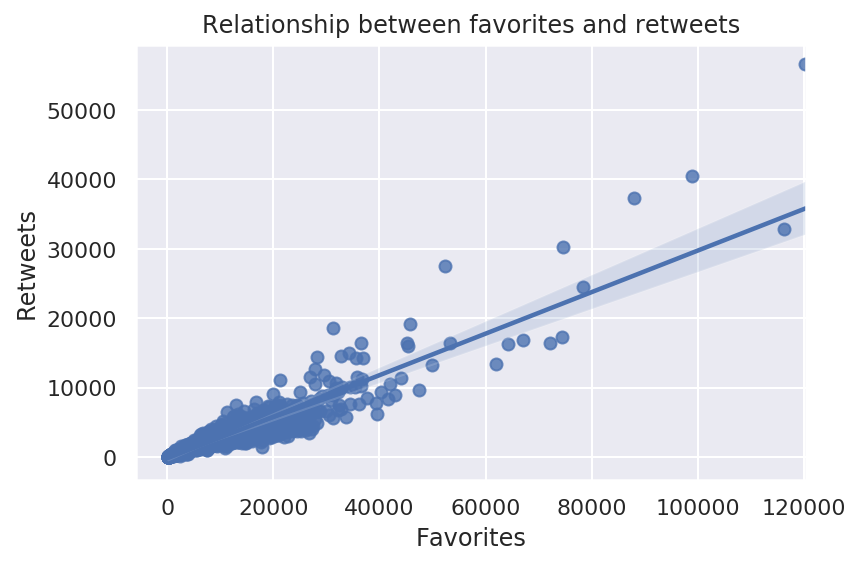

In [72]:
sns.set(color_codes=True)
rp = sns.regplot(x="favorite_count", y="retweet_count", data=df)
plt.title("Relationship between favorites and retweets")
plt.xlabel('Favorites')
plt.ylabel('Retweets')
rp.get_figure().savefig('img/fav_retweet_regplot.png', dpi=200, bbox_inches = "tight")

In [73]:
df['favorite_count'].corr(df['retweet_count'])

0.9256212882997505

### Most popular breed

In [74]:
def display_barh(df, title, xlabel, filename):
    ax = df.plot(kind='barh')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(None)
    plt.savefig(filename, dpi=200, bbox_inches="tight")

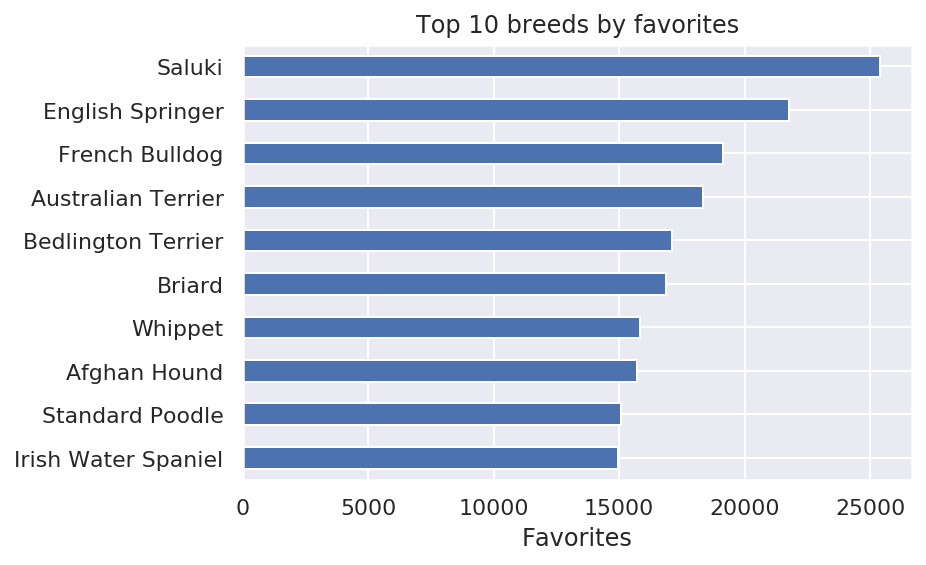

In [75]:
display_barh(
    df.groupby('breed').favorite_count.mean().sort_values().tail(10),
    'Top 10 breeds by favorites', 'Favorites', 'img/top10_breed_fav.png')

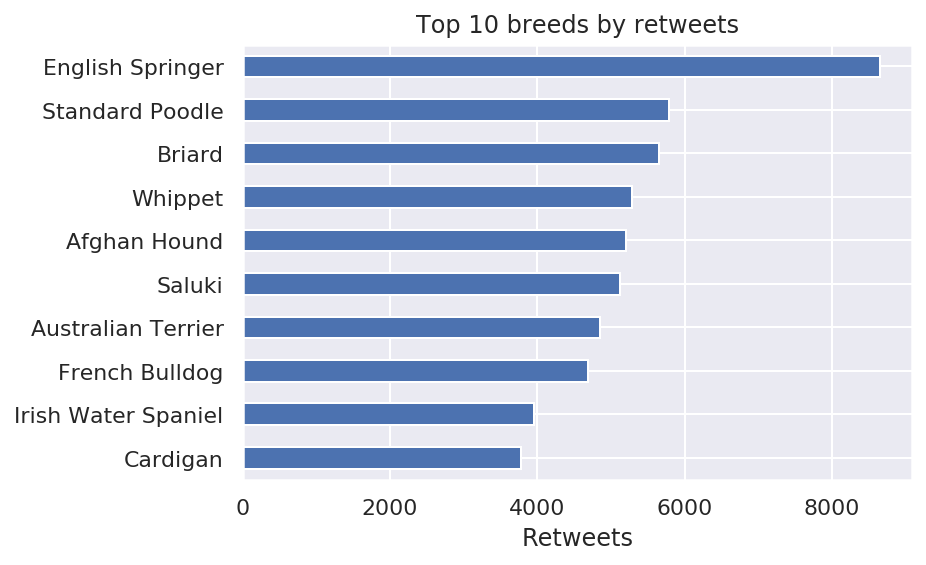

In [76]:
display_barh(
    df.groupby('breed').retweet_count.mean().sort_values().tail(10),
    'Top 10 breeds by retweets', 'Retweets', 'img/top10_breed_retweet.png')

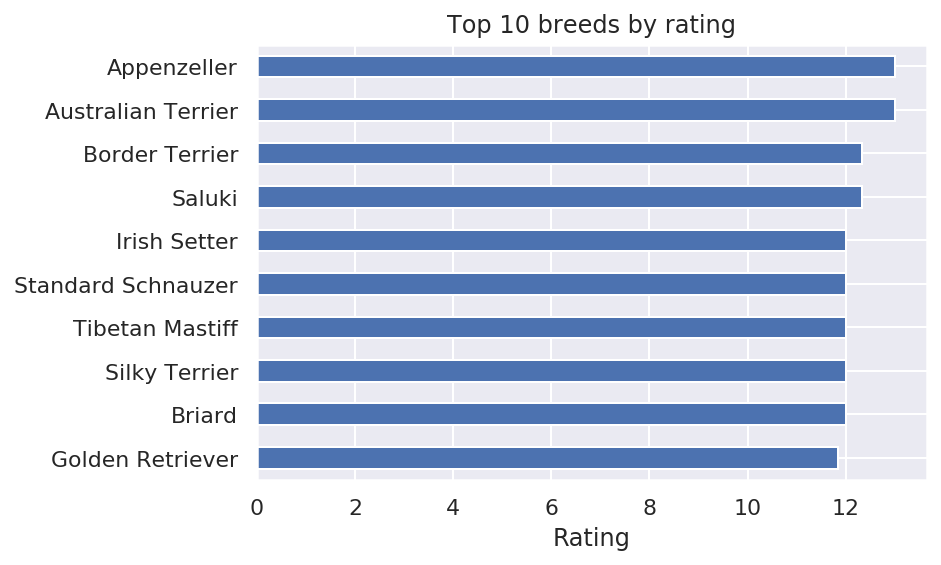

In [77]:
display_barh(
    df.groupby('breed').rating.mean().sort_values().tail(10),
    'Top 10 breeds by rating', 'Rating', 'img/top10_breed_rat.png')

### Neural Network Confidence

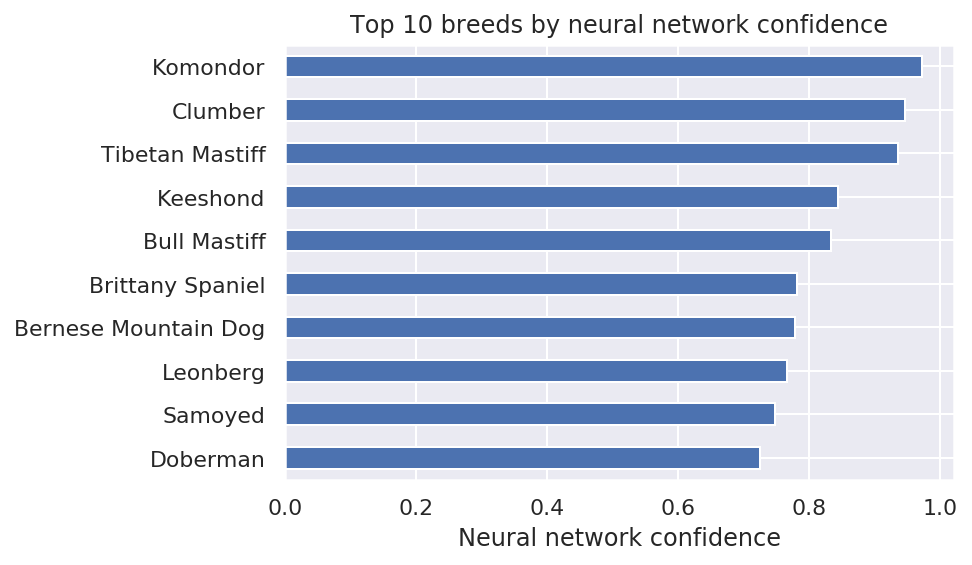

In [78]:
display_barh(
    df.groupby('breed').conf.mean().sort_values().tail(10),
    'Top 10 breeds by neural network confidence', 'Neural network confidence',
    'img/top10_breed_conf.png')

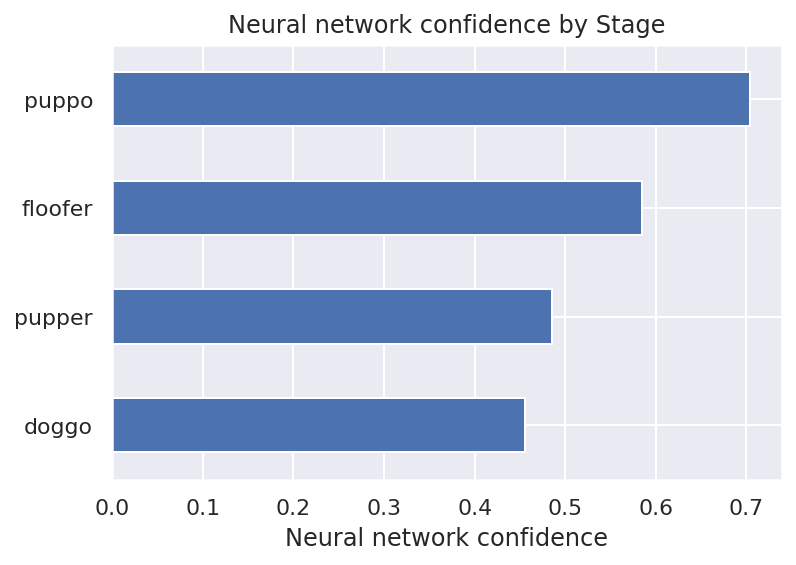

In [79]:
display_barh(
    df.groupby('stage').conf.mean().sort_values(),
    'Neural network confidence by Stage', 'Neural network confidence',
    'img/stage_conf.png')